In [168]:
'''
%pip install pandas
%pip install numpy
%pip install requests
%pip install lxml
%pip install yfinance
%pip install talib
%pip install sklearn
%pip install -U scikit-learn scipy matplotlib
%pip install pandas_ta
%pip install ta
%pip install pendulum'''

'\n%pip install pandas\n%pip install numpy\n%pip install requests\n%pip install lxml\n%pip install yfinance\n%pip install talib\n%pip install sklearn\n%pip install -U scikit-learn scipy matplotlib\n%pip install pandas_ta\n%pip install ta\n%pip install pendulum'

In [169]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Technical Indicators
import ta

#Standardize
from sklearn.preprocessing import StandardScaler

# Plotting graphs
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Data fetching
import yfinance as yf
yf.pdr_override()
import pendulum

 ## Import The Data

In [170]:
company = ['erw.bk','tisco.bk','sprc.bk']
stock = company[0] # Change index => 0 for The Erawan Group , 1 for TISCO Financial Group , and 2 for Star Petroleum Refining Public
stk = yf.Ticker(stock) 

start = pendulum.parse('2023-12-11 10:00')
end = pendulum.parse('2024-01-11 16:30')
df = stk.history(interval='15m',start=start,end=end)

df= df.iloc[:,:5]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 2023-12-12 10:00:00+07:00 to 2024-01-11 16:15:00+07:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    380 non-null    float64
 1   High    380 non-null    float64
 2   Low     380 non-null    float64
 3   Close   380 non-null    float64
 4   Volume  380 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 17.8 KB


Plot Stock Chart

In [171]:
fig = px.line(df, x=df.index, y='Close',template='plotly_dark', title='Stock Chart')
fig.update_traces(marker=dict(symbol='circle-open', size=8), line=dict(shape='linear'))
fig.show()

TEST

Define Predictor/Independent Variables

In [172]:
def indicators(data) :
    
    data['EMA'] = ta.trend.ema_indicator(close=data['Close'], window=20)
    data['RSI'] = ta.momentum.rsi(close=data['Close'], window=20) 
    data['BB_Upper'], _, data['BB_Lower'] = ta.volatility.bollinger_hband(close=data['Close'], window=20), ta.volatility.bollinger_mavg(close=data['Close'], window=20), ta.volatility.bollinger_lband(close=data['Close'], window=20)
    data['Stoch_Oscillator'] = ta.momentum.stoch(close=data['Close'], high=data['High'], low=data['Low'], window=20)
    data['ATR'] = ta.volatility.average_true_range(high=data['High'], low=data['Low'], close=data['Close'], window=20)
    data['OBV'] = ta.volume.on_balance_volume(close=data['Close'], volume=data['Volume'])
    data['ROC'] = ta.momentum.roc(close=data['Close'], window=20)
    
    #data['MACD'] = ta.trend.macd_diff(close=data['Close'], window_fast=10, window_slow=20, window_sign=5)
    #data['BB_Middle'] = ta.volatility.bollinger_mavg(close=data['Close'], window=20)
    #data['VWAP'] = ta.volume.volume_weighted_average_price(high=data['High'], low=data['Low'], close=data['Close'], volume=data['Volume'], window=20)
    #data['SMA'] = ta.trend.sma_indicator(close=data['Close'], window=20)

    data = data.dropna()
    return data


In [173]:
X = indicators(df)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2023-12-13 10:15:00+07:00 to 2024-01-11 16:15:00+07:00
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              360 non-null    float64
 1   High              360 non-null    float64
 2   Low               360 non-null    float64
 3   Close             360 non-null    float64
 4   Volume            360 non-null    int64  
 5   EMA               360 non-null    float64
 6   RSI               360 non-null    float64
 7   BB_Upper          360 non-null    float64
 8   BB_Lower          360 non-null    float64
 9   Stoch_Oscillator  360 non-null    float64
 10  ATR               360 non-null    float64
 11  OBV               360 non-null    int64  
 12  ROC               360 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 39.4 KB


Define Target

In [174]:
Y = np.where(X['Close'].shift(-1) > X['Close'],1,-1)
y = pd.DataFrame({'buy(1) or sell(-1)': Y})

Standardize Data 

In [175]:
scaler = StandardScaler()

x_scaled = scaler.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled , columns=X.columns)

Split The Dataset

In [176]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled , y, test_size=0.20, stratify=y, random_state=123)

# Logistic Regression

In [177]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

#Examine The Coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

c:\Users\chane\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,0,1
0,Open,[0.5668109581225081]
1,High,[0.6025697689518569]
2,Low,[0.04085994888919563]
3,Close,[-0.771256856459799]
4,Volume,[0.24511249713458297]
5,EMA,[0.0026633164918495027]
6,RSI,[-0.4390274609106868]
7,BB_Upper,[0.015368417671495068]
8,BB_Lower,[-0.13106919949909732]
9,Stoch_Oscillator,[-0.19748753522111906]


Calculate Class Probabilities & Predict Class Labels

In [178]:
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)
print(predicted)

[[0.94390485 0.05609515]
 [0.94214212 0.05785788]
 [0.92827339 0.07172661]
 [0.71163345 0.28836655]
 [0.84709701 0.15290299]
 [0.84830528 0.15169472]
 [0.7862668  0.2137332 ]
 [0.79047804 0.20952196]
 [0.93201411 0.06798589]
 [0.849566   0.150434  ]
 [0.89456292 0.10543708]
 [0.68426729 0.31573271]
 [0.83357942 0.16642058]
 [0.78549972 0.21450028]
 [0.86399258 0.13600742]
 [0.76918071 0.23081929]
 [0.77364904 0.22635096]
 [0.76998735 0.23001265]
 [0.85275335 0.14724665]
 [0.66410622 0.33589378]
 [0.87016299 0.12983701]
 [0.83044738 0.16955262]
 [0.82581845 0.17418155]
 [0.66884631 0.33115369]
 [0.85647657 0.14352343]
 [0.79988805 0.20011195]
 [0.84706341 0.15293659]
 [0.90820857 0.09179143]
 [0.6381521  0.3618479 ]
 [0.79636505 0.20363495]
 [0.91138604 0.08861396]
 [0.87230874 0.12769126]
 [0.84131256 0.15868744]
 [0.72010884 0.27989116]
 [0.74527438 0.25472562]
 [0.94688805 0.05311195]
 [0.46635739 0.53364261]
 [0.57750076 0.42249924]
 [0.89656175 0.10343825]
 [0.88799719 0.11200281]


## Evaluate The Model

Confusion Matrix & Classification Report

In [179]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[58  0]
 [13  1]]
              precision    recall  f1-score   support

          -1       0.82      1.00      0.90        58
           1       1.00      0.07      0.13        14

    accuracy                           0.82        72
   macro avg       0.91      0.54      0.52        72
weighted avg       0.85      0.82      0.75        72



### Model Accuracy

In [180]:
print(model.score(X_test,y_test))

0.8194444444444444


AUC

Area Under the Curve (AUC) is 0.7413793103448276


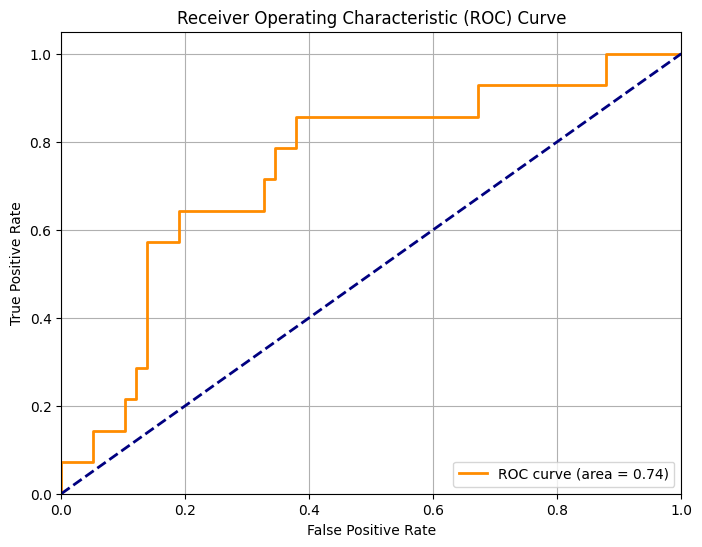

In [181]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

predicted_probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
 
roc_auc = auc(fpr, tpr)
print(f'Area Under the Curve (AUC) is {roc_auc}')

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


 --- ----

## Test 


In [182]:
start = pendulum.parse('2024-01-04 10:00')  # Please , do NOT change the start date here. We need previous data to calculate indicators
#end = pendulum.parse('2024-01-09 16:30') # Change the end date here,Ex. 2024-01-15 10:00:00+07:00
test_df = stk.history(interval='15m',start=start)
test_df= test_df.iloc[:,:5]

test_df = indicators(test_df)
test_df = test_df[test_df.index>= "2024-01-10 10:00:00+07:00	"]  #Change to start date Ex. 2024-01-15 10:00:00+07:00

test_scaled = scaler.fit_transform(test_df)
test_scaled = pd.DataFrame(test_scaled , columns=test_df.columns)

In [183]:
true_y= np.where(test_df['Close'].shift(-1) >test_df['Close'],1,-1)

In [184]:
print(model.score(test_scaled ,true_y))

0.8421052631578947


Area Under the Curve (AUC) is 0.8121212121212121


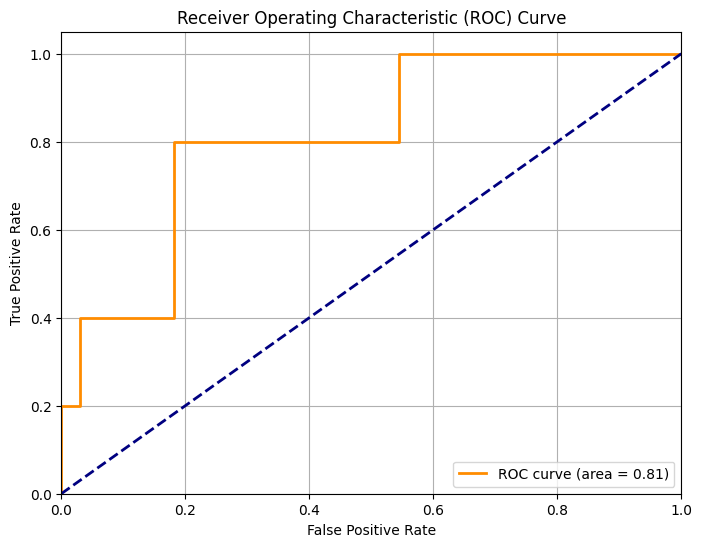

In [185]:
predicted_probabilities = model.predict_proba(test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(true_y, predicted_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
 
roc_auc = auc(fpr, tpr)
print(f'Area Under the Curve (AUC) is {roc_auc}')

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
